<center><img src="./images/nup_logo_dark.jpeg" width=300 style="display: inline-block;"></center> 

## Advanced Machine Learning
### EM Algorithm Practice

<br />
<br />
February 11, 2025


We will solve the problem of reconstructing a face image from a set of noisy images (taken from the deep bayes 2018 course https://github.com/bayesgroup/deepbayes-2018).

You have $K$ photographs damaged by electromagnetic noise. It is known that each photo contains a face in an unknown starting rectangular area of width $w$ and a background, the same for all photographs.

<center><img src="./images/example_and_structure.jpg" width=1000 style="display: inline-block;"></center> 
 

In [1]:
from matplotlib import pyplot as plt
import numpy as np

In [2]:
import zipfile
with zipfile.ZipFile('resources/data_em.zip', 'r') as zip_ref:
    zip_ref.extractall('tmp')

In [3]:
DATA_FILE = "tmp/data_em"
w = 73 # face_width

In [4]:
X = np.load(DATA_FILE)

/var/folders/r8/1llvc8sx345f0h_dnn8z50ph0000gp/T/ipykernel_23554/2324351789.py:1: UserWarning: Reading `.npy` or `.npz` file required additional header parsing as it was created on Python 2. Save the file again to speed up loading and avoid this warning.
  X = np.load(DATA_FILE)


In [5]:
X.shape # H, W, K

(100, 200, 1000)

(-0.5, 199.5, 99.5, -0.5)

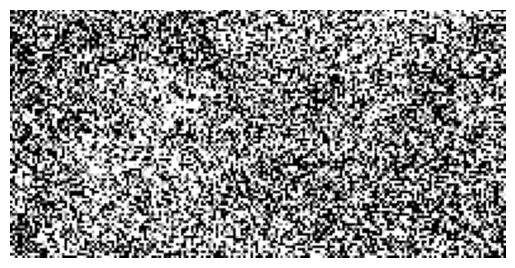

In [6]:
plt.imshow(X[:, :, 7], cmap="Greys_r")
plt.axis("off")

In [7]:
tH, tW, tw, tK = 2, 3, 1, 2
tX = np.arange(tH*tW*tK).reshape(tH, tW, tK)
tF = np.arange(tH*tw).reshape(tH, tw)
tB = np.arange(tH*tW).reshape(tH, tW)
ts = 0.1
ta = np.arange(1, (tW-tw+1)+1)
ta = ta / ta.sum()
tq = np.arange(1, (tW-tw+1)*tK+1).reshape(tW-tw+1, tK)
tq = tq / tq.sum(axis=0)[np.newaxis, :]

1. **Implement calculate_log_probability**
For the $k$-th picture $X_k$ and some position $d_k$: 
    $$ p(X_k \mid d_k,\,F,\,B,\, std) = \prod\limits_{ij}\begin{cases} 
        \mathcal{N}(X_k[i,j]\mid F[i,\,j-d_k],\, std^2), 
        & \text{if}\, (i,j)\in faceArea(d_k)\\
        \mathcal{N}(X_k[i,j]\mid B[i,j],\, std^2), & \text{else}
    \end{cases}
    $$
 
Remarks:
 * $faceArea(d_k) = \{[i, j]| d_k \leq j \leq d_k + w - 1 \}$
 * The prior distribution is given by the trainable vector $a \in \mathbb{R}^{W-w+1}$: $$p(d_k \mid a) = a[d_k],\ \sum\limits_j a[j] = 1$$
 * The final probability model: $$ p(X, d \mid F,B,std,a) = \prod\limits_k p(X_k \mid d_k,F,B,std) p(d_k \mid a)$$
 * Don't forget about the logarithm!
 * scipy.stats.norm might be useful for you.

In [8]:
import scipy.stats

In [9]:
def calculate_log_probability(X, F, B, s):
    """
    Calculates log p(X_k|d_k, F, B, s) for all images X_k in X and
    all possible face positions d_k

    Parameters
    ----------
    X: array, shape (H, W, K)
        K images of size H x W
    F: array, shape (H, w)
        Estimate of prankster's face
    B: array, shape (H, W)
        Estimate of a background
    s: float
        Estimate of standard deviation in Gaussian noise

    Returns
    -------
    ll: array, shape(W-w+1, K)
        ll[dw, k] - log-likelihood of observing image X_k given
        that the prankster's face F is located at position dw
    """
    H, W, K = X.shape
    _, w = F.shape
    # your code starts here
    ll = np.zeros((W-w+1, K))
    for dw in range(W-w+1):
        combined = np.copy(B)
        combined[:, dw:dw+w] = F
        d_combined = X - np.expand_dims(combined, 2)
        ll[dw] = scipy.stats.norm(0, s).logpdf(d_combined).sum(axis=(0,1))
    return ll
    # your code ends here


In [10]:
# run this cell to test your implementation
expected = np.array([[-3541.69812064, -5541.69812064],
       [-4541.69812064, -6741.69812064],
       [-6141.69812064, -8541.69812064]])
actual = calculate_log_probability(tX, tF, tB, ts)
assert np.allclose(actual, expected)
print("OK")

OK


2. **Implement calculate_lower_bound**

\begin{equation}\mathscr{L}(q, F, B, s, a) = \sum_k \biggl (\mathbb{E} _ {q( d_k)}\bigl ( \log p( X_{k} \mid {d}_{k} , F,B,s) + \log p( d_k \mid a)\bigr) - \mathbb{E} _ {q( d_k)} \log q( d_k)\biggr) \end{equation}

Remarks:
 * Use calculate_log_probability!
 * Note that $q( d_k)$ and $p( d_k \mid a)$ are discrete. For example, $P(d_k=i \mid a) = a[i]$

In [11]:
def calculate_lower_bound(X, F, B, s, a, q):
    """
    Calculates the lower bound L(q, F, B, s, a) for 
    the marginal log likelihood.

    Parameters
    ----------
    X: array, shape (H, W, K)
        K images of size H x W
    F: array, shape (H, w)
        Estimate of prankster's face
    B: array, shape (H, W)
        Estimate of background
    s: float
        Estimate of standard deviation in Gaussian noise
    a: array, shape (W-w+1)
        Estimate of prior on face position in any image
    q: array
        q[dw, k] - estimate of posterior 
                   of position dw
                   of prankster's face given image Xk

    Returns
    -------
    L : float
        The lower bound L(q, F, B, s, a) 
        for the marginal log likelihood.
    """
    # your code starts here
    return (q * (calculate_log_probability(X,F,B,s) + np.expand_dims(np.log(a), 1) -  np.log(q))).sum()
    # your code ends here

In [12]:
calculate_lower_bound(tX, tF, tB, ts, ta, tq)

-12761.187501001436

In [13]:
# run this cell to test your implementation
expected = -12761.1875
actual = calculate_lower_bound(tX, tF, tB, ts, ta, tq)
assert np.allclose(actual, expected)
print("OK")

OK


3. **Implement E-step**
$$q(d_k) = p(d_k \mid X_k, \,F, \,B, \,s,\, a) = 
\frac {p(  X_{k}  \mid {d}_{k} , \,F,\,B,\,s)\, p(d_k \mid a)}
{\sum_{d'_k} p(  X_{k}  \mid d'_k , \,F,\,B,\,s) \,p(d'_k \mid a)}$$

Remarks:
 * Use calculate_log_probability!
 * Calculate in logarithms, exponentiate at the end
 * It is recommended to use the following statement for computational stability: $$\beta_i = \log{p_i(\dots)} \quad\rightarrow \quad \frac{e^{\beta_i}}{\sum\limits_k e^{\beta_k}} = \frac{e^{(\beta_i - \max_j \beta_j)}}{\sum\limits_k e^{(\beta_k- \max_j \beta_j)}}$$


In [14]:
def run_e_step(X, F, B, s, a):
    """
    Given the current esitmate of the parameters, for each image Xk
    esitmates the probability p(d_k|X_k, F, B, s, a).

    Parameters
    ----------
    X: array, shape(H, W, K)
        K images of size H x W.
    F: array_like, shape(H, w)
        Estimate of prankster's face
    B: array shape(H, W)
        Estimate of background
    s: float
        Estimate of standard deviation in Gaussian noise
    a: array, shape(W-w+1)
        Estimate of prior on face position in any image

    Returns
    -------
    q : array
        shape (W-w+1, K)
        q[dw, k] - estimate of posterior of position dw
        of prankster's face given image Xk
    """
    # your code starts here
    log_nom = calculate_log_probability(X,F,B,s) + np.expand_dims(np.log(a), 1)
    mx = log_nom.max(axis=0)
    nom = np.exp(log_nom - mx)
    return nom / nom.sum(axis=0)
    # your code ends here


In [15]:
run_e_step(tX, tF, tB, ts, ta)

array([[1., 1.],
       [0., 0.],
       [0., 0.]])

In [16]:
# run this cell to test your implementation
expected = np.array([[ 1.,  1.],
                   [ 0.,  0.],
                   [ 0.,  0.]])
actual = run_e_step(tX, tF, tB, ts, ta)
assert np.allclose(actual, expected)
print("OK")

OK


4. **Implement M-step**

We need to implement the
\begin{equation}\mathscr{L}(q, \,F, \,B,\, s,\, a) = \sum_k \biggl (\mathbb{E} _ {q( d_k)}\bigl ( \log p(  X_{k}  \mid {d}_{k} , \,F,\,B,\,s) + 
    \log p( d_k \mid a)\bigr) - \mathbb{E} _ {q( d_k)} \log q( d_k)\biggr)\rightarrow \max\limits_{\theta, a} \end{equation}

After a long calculation, we obtain:
$$a[j] = \frac{\sum_k q( d_k = j )}{\sum_{j'}  \sum_{k'} q( d_{k'} = j')}$$$$F[i, m] = \frac 1 K  \sum_k \sum_{d_k} q(d_k)\, X^k[i,\, m+d_k]$$\begin{equation}B[i, j] = \frac {\sum_k \sum_{ d_k:\, (i, \,j) \,\not\in faceArea(d_k)} q(d_k)\, X^k[i, j]} 
        {\sum_k \sum_{d_k: \,(i, \,j)\, \not\in faceArea(d_k)} q(d_k)}\end{equation}\begin{equation}s^2 = \frac 1 {HWK}   \sum_k \sum_{d_k} q(d_k)
        \sum_{i,\, j}  (X^k[i, \,j] - Model^{d_k}[i, \,j])^2\end{equation}
where $Model^{d_k}[i, j]$ is the picture made from the background and face shifted to $d_k$.

Remarks:
 * Update parameters in the order: $a$, $F$, $B$, $s$
 * Use the updated parameter to estimate the next parameter        


In [17]:
def run_m_step(X, q):
    """
    Estimates F, B, s, a given estimate of posteriors defined by q.

    Parameters
    ----------
    X: array, shape (H, W, K)
        K images of size H x W.
    q:
        q[dw, k] - estimate of posterior of position dw
                   of prankster's face given image Xk
    w: int
        Face mask width.

    Returns
    -------
    F: array, shape (H, w)
        Estimate of prankster's face.
    B: array, shape (H, W)
        Estimate of a background.
    s: float
        Estimate of standard deviation of Gaussian noise.
    a: array, shape (W-w+1)
        Estimate of prior on position of face in any image.
    """
# your code starts here
    H, W, K = X.shape
    dw, _ = q.shape
    w = W - dw + 1

    a = q.sum(axis=1)/q.sum()
    
    F = np.zeros((H, w))
    for dk in range(dw):
        F += (q[dk] * X[:, dk:dk+w]).sum(axis=2) / K
    
    B = np.zeros((H, W))
    denom = np.zeros((H, W))
    for dk in range(dw):
        if dk > 0:
            denom[:, :dk] += q[dk].sum()
            B[:, :dk] += (q[dk] * X[:, :dk]).sum(axis=2)
        if dk + w < W:
            B[:, dk+w:] += (q[dk] * X[:, dk+w:]).sum(axis=2)
            denom[:, dk + w:] += q[dk].sum()
    B /= denom
    
    s2 = 0
    for dk in range(dw):
        model = np.copy(B)
        model[:, dk:dk+w] = F
        s2 += (q[dk] * ((X - np.expand_dims(model,2)) ** 2)).sum()
    s2 /= H * W * K
    
    return F, B, np.sqrt(s2), a


In [18]:
run_m_step(tX, tq)

(array([[3.27777778],
        [9.27777778]]),
 array([[ 0.48387097,  2.5       ,  4.52941176],
        [ 6.48387097,  8.5       , 10.52941176]]),
 0.9486806229147358,
 array([0.13888889, 0.33333333, 0.52777778]))

In [19]:
# run this cell to test your implementation
expected = [np.array([[ 3.27777778],
                      [ 9.27777778]]),
 np.array([[  0.48387097,   2.5       ,   4.52941176],
           [  6.48387097,   8.5       ,  10.52941176]]),
  0.94868,
 np.array([ 0.13888889,  0.33333333,  0.52777778])]
actual = run_m_step(tX, tq)
for a, e in zip(actual, expected):
    assert np.allclose(a, e)
print("OK")

OK


5. **Implement EM algorithm**

In [20]:
def run_EM(X, w, F=None, B=None, s=None, a=None, 
           tolerance=0.001,
           max_iter=50):
    """
    Runs EM loop until the likelihood of observing X given current
    estimate of parameters is idempotent as defined by a fixed
    tolerance.

    Parameters
    ----------
    X: array, shape (H, W, K)
        K images of size H x W
    w: int
        Face mask width
    F: array, shape (H, w), optional
        Initial estimate of prankster's face
    B: array, shape (H, W), optional
        Initial estimate of a background
    s: float, optional
        Initial estimate of standard deviation of Gaussian noise
    a: array, shape (W-w+1), optional
        Initial estimate of prior on position of face in any image
    tolerance : float, optional
        Parameter for a stopping criterion
    max_iter  : int, optional
        Maximum number of iterations

    Returns
    -------
    F, B, s, a : trained parameters
    """
    # your code here
    H, W, N = X.shape
    if F is None:
        F = np.random.randint(0, 255, (H, w))
    if B is None:
        B = np.random.randint(0, 255, (H, W))
    if a is None:
        a = np.ones(W - w + 1)
        a /= np.sum(a)
    if s is None:
        s = np.random.rand()*64*64
    l_prev = -np.inf
    for it in range(max_iter):
        print(f"iteration = {it}")
        q = run_e_step(X, F, B, s, a)
        print("e-step is done!")
        F, B, s, a = run_m_step(X, q)
        print("m-step is done!")
        print(s)
        if it == max_iter - 1:
            print("no convergence")
            break
        l_cur = calculate_lower_bound(X, F, B, s, a, q)
        if l_cur - l_prev < tolerance:
            print(f"converged in {it} iterations {l_cur - l_prev}")
            break
        else:
            l_prev = l_cur
  
    return F, B, s, a

Deciphering the picture:

In [21]:
def show(F, i=1, n=1):
    """
    shows face F at subplot i out of n
    """
    plt.subplot(1, n, i)
    plt.imshow(F, cmap="Greys_r")
    plt.axis("off")

iteration = 0
e-step is done!
m-step is done!
114.91669196197181
iteration = 1
e-step is done!
m-step is done!
114.19096756877312
iteration = 2
e-step is done!
m-step is done!
113.93942385099568
iteration = 3
e-step is done!
m-step is done!
113.93564632589342


/var/folders/r8/1llvc8sx345f0h_dnn8z50ph0000gp/T/ipykernel_23554/2286775707.py:30: RuntimeWarning: divide by zero encountered in log
  return (q * (calculate_log_probability(X,F,B,s) + np.expand_dims(np.log(a), 1) -  np.log(q))).sum()
/var/folders/r8/1llvc8sx345f0h_dnn8z50ph0000gp/T/ipykernel_23554/2286775707.py:30: RuntimeWarning: invalid value encountered in multiply
  return (q * (calculate_log_probability(X,F,B,s) + np.expand_dims(np.log(a), 1) -  np.log(q))).sum()


iteration = 4
e-step is done!
m-step is done!
113.93564632589343
no convergence
113.93564632589343
iteration = 0
e-step is done!
m-step is done!
114.56253622049968
no convergence
114.56253622049968
iteration = 0
e-step is done!
m-step is done!
114.82500671784608
no convergence
114.82500671784608
iteration = 0
e-step is done!
m-step is done!
114.76203958476619
no convergence
114.76203958476619
iteration = 0
e-step is done!
m-step is done!
114.81017045134055
no convergence
114.81017045134055
CPU times: user 1min 5s, sys: 20 s, total: 1min 25s
Wall time: 1min 25s


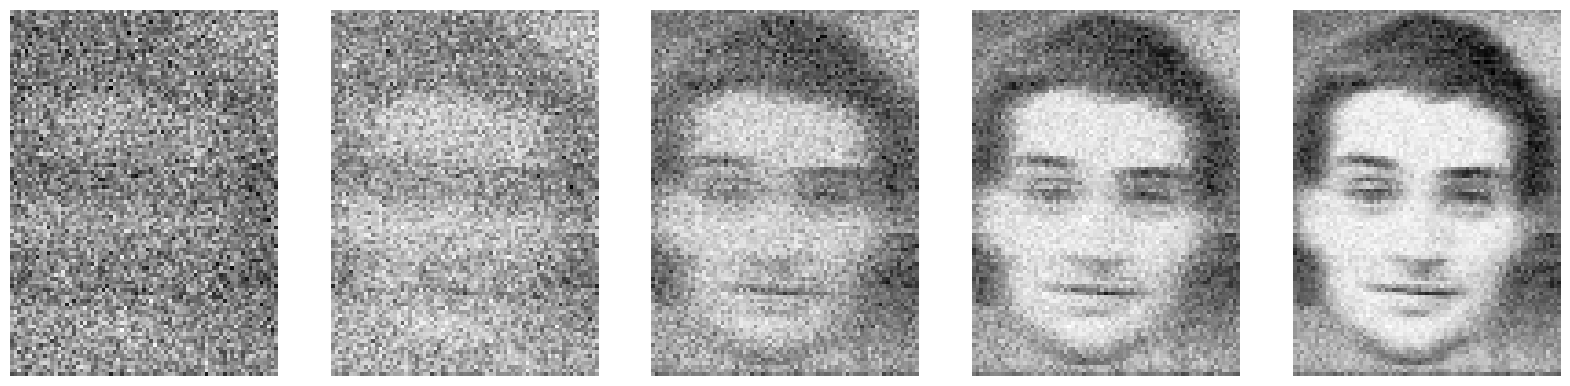

In [22]:
%%time
F, B, s, a = [None] * 4
lens = [50, 100, 300, 500, 1000]
iters = [5, 1, 1, 1, 1]
plt.figure(figsize=(20, 5))
for i, (l, it) in enumerate(zip(lens, iters)):
    F, B, s, a = run_EM(X[:, :, :l], w, F, B, s, a, max_iter=it)
    print(s)
    show(F, i+1, 5)

And a background:

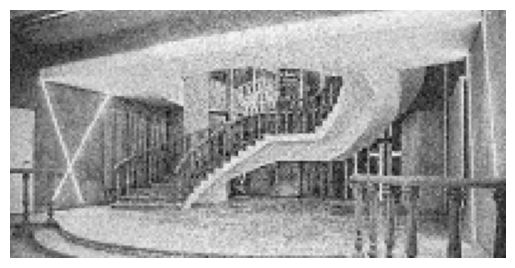

In [23]:
show(B)